In [9]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler

class CancerClassifier:
    def __init__(self):
        self.breast_labels = None
        self.breast_train = None
        self.breast_validate = None
        self.scaler = StandardScaler()
        self.feature_names = []
        self.quadratic_feature_indices = []
        
    def read_data(self):
        # Wczytanie danych
        self.breast_labels = pd.read_csv("dataset/breast-cancer.labels", header=None)[0].tolist()
        self.breast_train = pd.read_csv("dataset/breast-cancer-train.dat", header=None)
        self.breast_validate = pd.read_csv("dataset/breast-cancer-validate.dat", header=None)
        self.breast_train.columns = self.breast_labels
        self.breast_validate.columns = self.breast_labels
        
        self.feature_names = [col for col in self.breast_train.columns 
                             if col not in ['patient ID', 'Malignant/Benign']]
        
        quadratic_features = ['radius (mean)', 'perimeter (mean)', 'area (mean)', 'symmetry (mean)']
        self.quadratic_feature_indices = [self.feature_names.index(f) for f in quadratic_features]
    
    def _prepare_data(self, df, scaler=None):
        """Przygotowanie danych: usunięcie ID, mapowanie targetu, normalizacja, dodanie biasu"""
        # Kopia danych
        data = df.copy()
        
        if 'patient ID' in data.columns:
            data = data.drop(columns=['patient ID'])
        
        data['Malignant/Benign'] = data['Malignant/Benign'].map({'M': 1, 'B': 0})
        
        y = data['Malignant/Benign'].values
        X = data.drop(columns=['Malignant/Benign']).values
        
        if scaler is None:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
        else:
            X_scaled = scaler.transform(X)
        
        X_final = np.c_[np.ones(X_scaled.shape[0]), X_scaled]
        
        return X_final, y, scaler
    
    # Metody z poprzedniego laboratorium
    def create_linear_matrix(self, X):
        """Tworzy macierz cech z dodanym biasem"""
        return np.c_[np.ones(X.shape[0]), X]
    
    def create_quadratic_matrix(self, X):
        """Tworzy macierz cech dla reprezentacji kwadratowej"""
        # Wybór odpowiednich cech
        X_sub = X[:, self.quadratic_feature_indices]
        
        # Terminy liniowe i kwadratowe
        X_squared = X_sub ** 2
        
        # Terminy interakcyjne
        interactions = []
        n_features = X_sub.shape[1]
        for i in range(n_features):
            for j in range(i+1, n_features):
                interactions.append(X_sub[:, i] * X_sub[:, j])
        interactions = np.column_stack(interactions) if interactions else np.zeros((X_sub.shape[0], 0))
        
        # Połączenie wszystkich terminów
        return np.hstack((X_sub, X_squared, interactions))
    
    def create_target_vector(self, df):
        """Tworzy wektor celu (1 dla M, -1 dla B)"""
        return np.where(df['Malignant/Benign'] == 'M', 1, -1)
    
    def compute_weights(self, A, b):
        """Oblicza wagi metodą równania normalnego"""
        ATA = A.T @ A
        ATb = A.T @ b
        return np.linalg.solve(ATA, ATb)
    
    def compute_weights_SVD(self, A, lambda_coeff, b):
        """Oblicza wagi z regularyzacją SVD"""
        ATA = A.T @ A 
        ATA += lambda_coeff * np.identity(A.shape[1])
        ATb = A.T @ b
        return np.linalg.lstsq(ATA, ATb, rcond=None)[0]
    
    # Metody dla GD
    def _compute_learning_rate(self, A):
        """Obliczenie stałej uczącej na podstawie wartości własnych"""
        X = A.T @ A
        eigenvalues = np.linalg.eigvals(X)
        lambda_max = np.max(eigenvalues)
        return 1.0 / lambda_max
    
    def gradient_descent(self, X, y, alpha, max_iters=10000, tol=1e-6):
        """Implementacja gradient_descent"""
        n_samples, n_features = X.shape
        beta = np.zeros(n_features)
        start_ns = time.perf_counter_ns()
        
        for i in range(max_iters):
            # Obliczenie predykcji i błędu
            y_pred = X @ beta
            error = y_pred - y
            
            # Obliczenie gradientu
            gradient = (X.T @ error) / n_samples
            
            # Aktualizacja wag
            beta_new = beta - alpha * gradient
            
            # Warunek stopu
            if np.linalg.norm(beta_new - beta) < tol:
                beta = beta_new
                break
                
            beta = beta_new
        
        time_elapsed_ns = time.perf_counter_ns() - start_ns
        return beta, time_elapsed_ns
    
    def predict_01(self, X, beta, threshold=0.5):
        """Predykcja dla etykiet 0/1"""
        y_continuous = X @ beta
        return (y_continuous >= threshold).astype(int)
    
    def predict_1m(self, X, beta):
        """Predykcja dla etykiet 1/-1"""
        y_continuous = X @ beta
        return np.sign(y_continuous)
    
    def accuracy(self, y_true, y_pred):
        """Obliczenie dokładności"""
        return np.mean(y_true == y_pred)
    
    def run(self):
        # Przygotowanie danych treningowych
        self.read_data()
        X_train, y_train, scaler = self._prepare_data(self.breast_train)
        
        # Przygotowanie danych do walidacji
        X_val, y_val, _ = self._prepare_data(self.breast_validate, scaler)
        
        # Dane bez kolumny biasu dla metod z poprzedniego laboratorium
        X_train_no_bias = X_train[:, 1:]
        X_val_no_bias = X_val[:, 1:]
        
        # Obliczenie stałej uczącej dla GD
        alpha = self._compute_learning_rate(X_train)
        print(f"Obliczona stała ucząca: {alpha:.6f}")
        
        # Gradient Descent (reprezentacja liniowa)
        beta_gd, time_gd_ns = self.gradient_descent(X_train, y_train, alpha)
        y_pred_gd = self.predict_01(X_val, beta_gd)
        acc_gd = self.accuracy(y_val, y_pred_gd)
        
        # Least Squares - Równanie normalne (liniowa)
        A_lin_train = self.create_linear_matrix(X_train_no_bias)
        A_lin_val = self.create_linear_matrix(X_val_no_bias)
        b_train_1m = self.create_target_vector(self.breast_train)
        
        start_ns = time.perf_counter_ns()
        weights_lin_normal = self.compute_weights(A_lin_train, b_train_1m)
        time_lin_normal_ns = time.perf_counter_ns() - start_ns
        y_pred_lin_normal = self.predict_1m(A_lin_val, weights_lin_normal)
        y_pred_lin_normal_01 = (y_pred_lin_normal > 0).astype(int)
        acc_lin_normal = self.accuracy(y_val, y_pred_lin_normal_01)
        
        # Least Squares - Równanie normalne (kwadratowa)
        A_quad_train = self.create_quadratic_matrix(X_train_no_bias)
        A_quad_val = self.create_quadratic_matrix(X_val_no_bias)
        
        start_ns = time.perf_counter_ns()
        weights_quad_normal = self.compute_weights(A_quad_train, b_train_1m)
        time_quad_normal_ns = time.perf_counter_ns() - start_ns
        y_pred_quad_normal = self.predict_1m(A_quad_val, weights_quad_normal)
        y_pred_quad_normal_01 = (y_pred_quad_normal > 0).astype(int)
        acc_quad_normal = self.accuracy(y_val, y_pred_quad_normal_01)
        
        # Least Squares - SVD bez regularyzacji
        start_ns = time.perf_counter_ns()
        weights_lin_svd = self.compute_weights_SVD(A_lin_train, 0.0, b_train_1m)
        time_lin_svd_ns = time.perf_counter_ns() - start_ns
        y_pred_lin_svd = self.predict_1m(A_lin_val, weights_lin_svd)
        y_pred_lin_svd_01 = (y_pred_lin_svd > 0).astype(int)
        acc_lin_svd = self.accuracy(y_val, y_pred_lin_svd_01)
        
        # Least Squares - SVD z regularyzacją
        start_ns = time.perf_counter_ns()
        weights_lin_reg = self.compute_weights_SVD(A_lin_train, 0.001, b_train_1m)
        time_lin_reg_ns = time.perf_counter_ns() - start_ns
        y_pred_lin_reg = self.predict_1m(A_lin_val, weights_lin_reg)
        y_pred_lin_reg_01 = (y_pred_lin_reg > 0).astype(int)
        acc_lin_reg = self.accuracy(y_val, y_pred_lin_reg_01)
        
        # Wyniki
        results = [
            ("Gradient Descent", acc_gd, time_gd_ns, "O(k·n·p)"),
            ("LS (Normal Eq - Linear)", acc_lin_normal, time_lin_normal_ns, "O(n·p² + p³)"),
            ("LS (Normal Eq - Quadratic)", acc_quad_normal, time_quad_normal_ns, "O(n·q² + q³)"),
            ("LS (SVD)", acc_lin_svd, time_lin_svd_ns, "O(min(n²·p, n·p²))"),
            ("LS (Regularized SVD)", acc_lin_reg, time_lin_reg_ns, "O(min(n²·p, n·p²))")
        ]
        
        # Printowanie wyników
        print(f"{'Metoda':<30} | {'Dokładność':<10} | {'Czas [s]':<12} | {'Złożoność teoretyczna'}")
        print("-"*100)
        for method, acc, t_ns, comp in results:
            print(f"{method:<30} | {acc:.6f}   | {t_ns / 10e9 :<12f} | {comp}")
        print("gdzie: k to liczba iteracji - n liczba próbek - p liczba cech. q - liczba cech w macierzy kwadratowej")
        print("="*100)
        
        return results

# Uruchomienie klasyfikatora
if __name__ == "__main__":
    classifier = CancerClassifier()
    classifier.run()


Obliczona stała ucząca: 0.000256
Metoda                         | Dokładność | Czas [s]     | Złożoność teoretyczna
----------------------------------------------------------------------------------------------------
Gradient Descent               | 0.984615   | 0.080280     | O(k·n·p)
LS (Normal Eq - Linear)        | 0.973077   | 0.000283     | O(n·p² + p³)
LS (Normal Eq - Quadratic)     | 0.926923   | 0.000040     | O(n·q² + q³)
LS (SVD)                       | 0.973077   | 0.001013     | O(min(n²·p, n·p²))
LS (Regularized SVD)           | 0.973077   | 0.000043     | O(min(n²·p, n·p²))
gdzie: k to liczba iteracji - n liczba próbek - p liczba cech. q - liczba cech w macierzy kwadratowej


=== OPTYMALIZACJA ŚCIEŻKI ROBOTA ===
Parametry:
- Liczba odcinków (n): 20
- Liczba przeszkód (k): 50
- Punkt startowy: [0 0]
- Punkt końcowy: [20 20]
- λ₁ = 1, λ₂ = 1
- ε = 1e-13
- Maksymalna liczba iteracji: 400

--- PRÓBA 1 ---
Iteracja 0: F = 3098.650600, ||grad|| = 276.182580
Iteracja 50: F = 86.038804, ||grad|| = 1.676710
Iteracja 100: F = 77.658309, ||grad|| = 0.203040
Iteracja 150: F = 77.270660, ||grad|| = 0.140183
Iteracja 200: F = 77.213234, ||grad|| = 0.028841
Iteracja 250: F = 77.210614, ||grad|| = 0.006476
Iteracja 300: F = 77.210483, ||grad|| = 0.001444
Iteracja 350: F = 77.210477, ||grad|| = 0.000322
Wartość końcowa funkcji celu: 77.210476


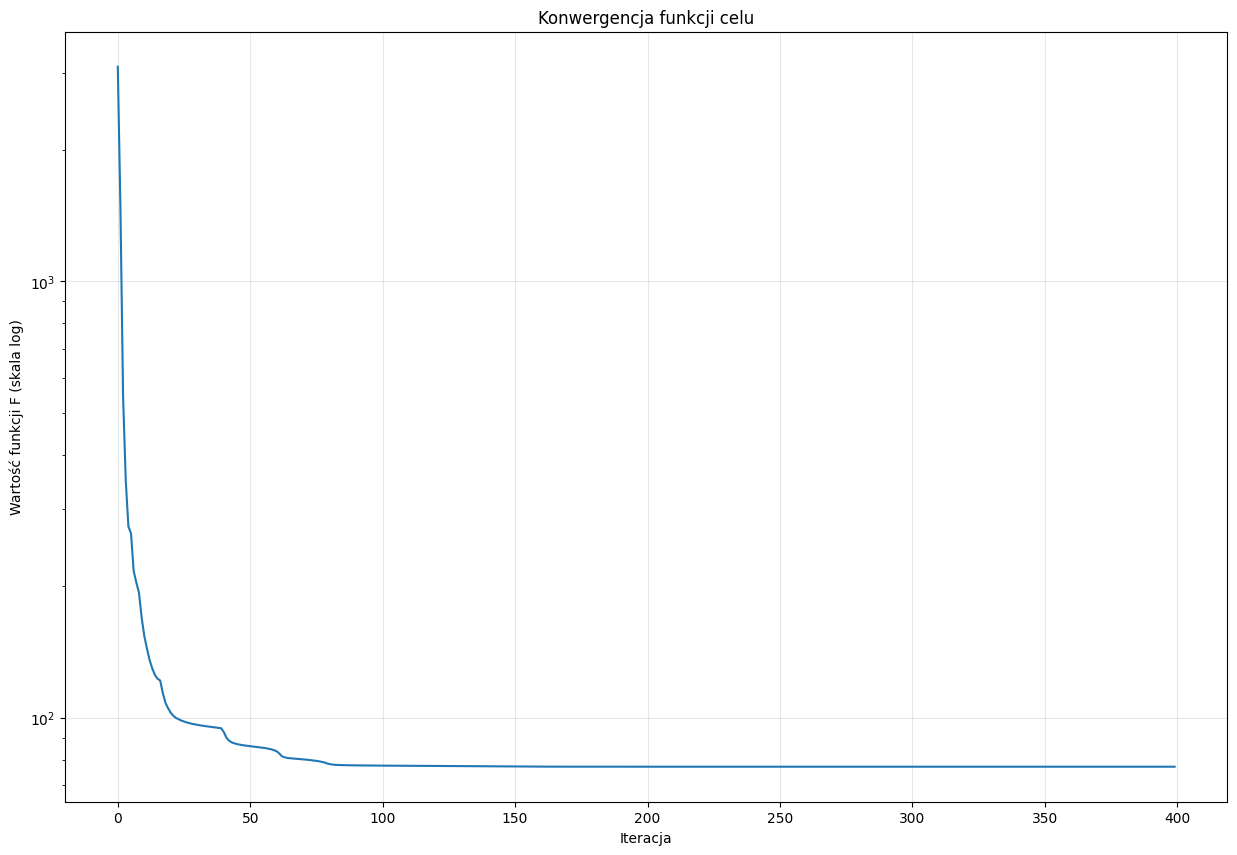

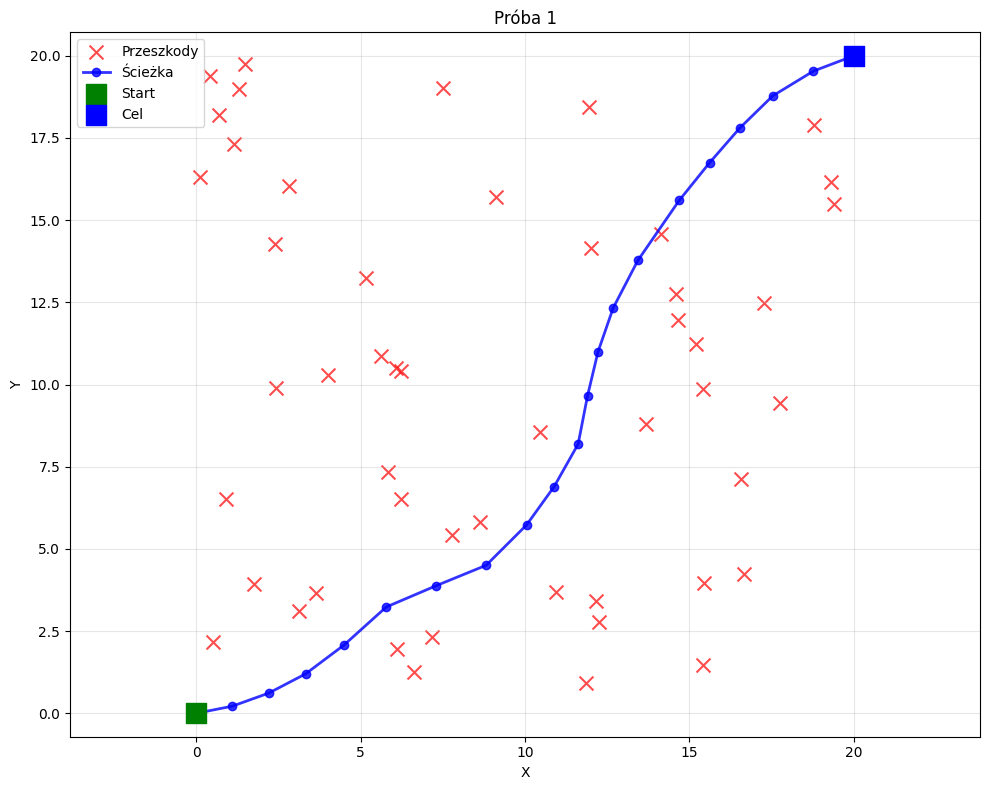


--- PRÓBA 2 ---
Iteracja 0: F = 3452.468449, ||grad|| = 200.931808
Iteracja 50: F = 84.638434, ||grad|| = 1.978625
Iteracja 100: F = 77.645466, ||grad|| = 0.200812
Iteracja 150: F = 77.252957, ||grad|| = 0.115742
Iteracja 200: F = 77.212125, ||grad|| = 0.022035
Iteracja 250: F = 77.210544, ||grad|| = 0.004503
Iteracja 300: F = 77.210479, ||grad|| = 0.000919
Iteracja 350: F = 77.210476, ||grad|| = 0.000192
Wartość końcowa funkcji celu: 77.210476


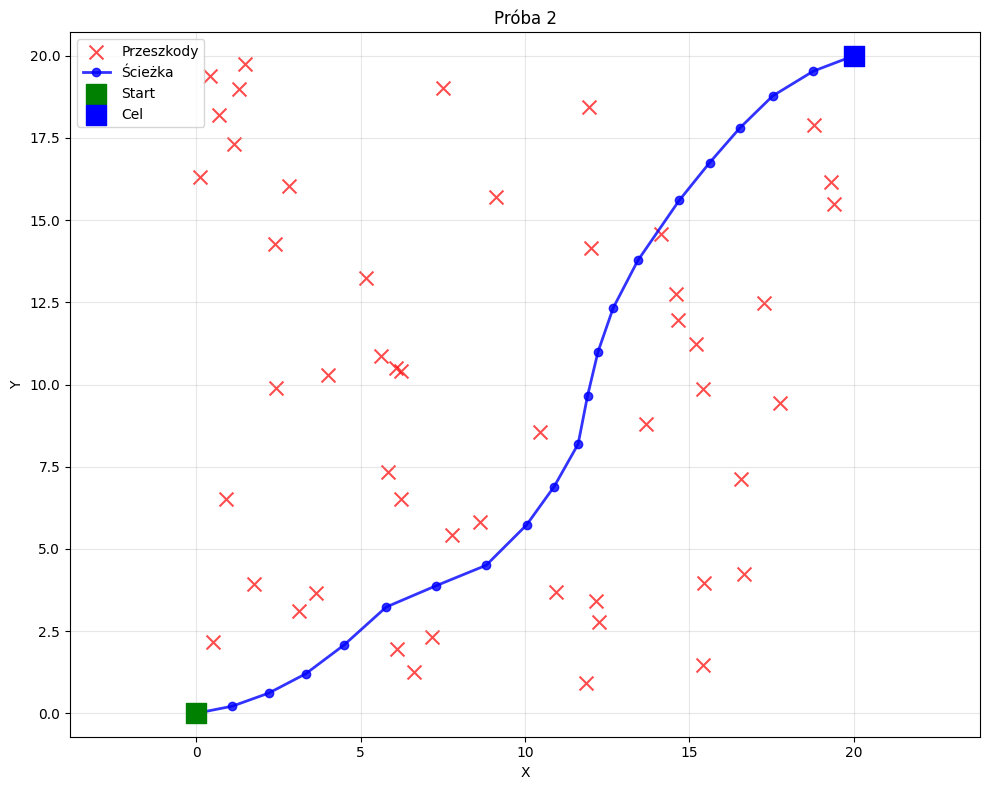


--- PRÓBA 3 ---
Iteracja 0: F = 4466.333931, ||grad|| = 13070.525157
Iteracja 50: F = 82.072737, ||grad|| = 3.033566
Iteracja 100: F = 76.569102, ||grad|| = 0.162470
Iteracja 150: F = 75.856733, ||grad|| = 0.623679
Iteracja 200: F = 73.557180, ||grad|| = 0.224801
Iteracja 250: F = 72.756604, ||grad|| = 0.089647
Iteracja 300: F = 72.669458, ||grad|| = 0.028888
Iteracja 350: F = 72.665270, ||grad|| = 0.003593
Wartość końcowa funkcji celu: 72.665219


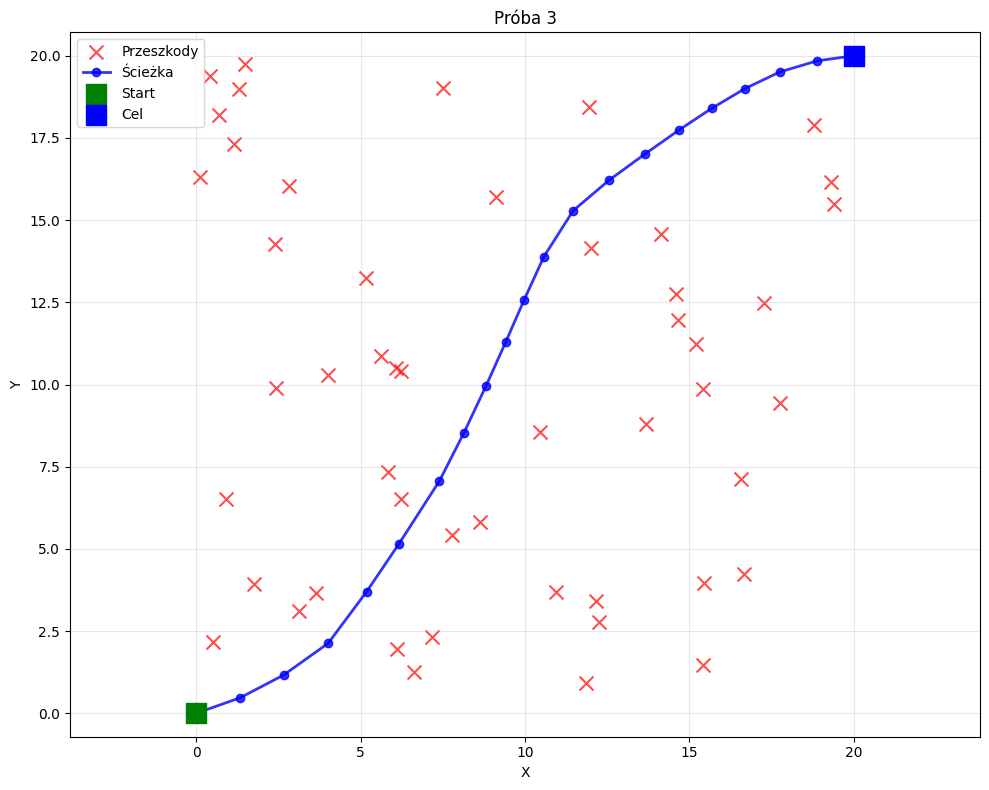


--- PRÓBA 4 ---
Iteracja 0: F = 2952.019699, ||grad|| = 177.349356
Iteracja 50: F = 82.307506, ||grad|| = 1.949636
Iteracja 100: F = 75.396520, ||grad|| = 0.263083
Iteracja 150: F = 75.340392, ||grad|| = 0.061129
Iteracja 200: F = 74.703013, ||grad|| = 0.514160
Iteracja 250: F = 73.806212, ||grad|| = 0.090860
Iteracja 300: F = 73.775800, ||grad|| = 0.020650
Iteracja 350: F = 73.773869, ||grad|| = 0.006202
Wartość końcowa funkcji celu: 73.773679


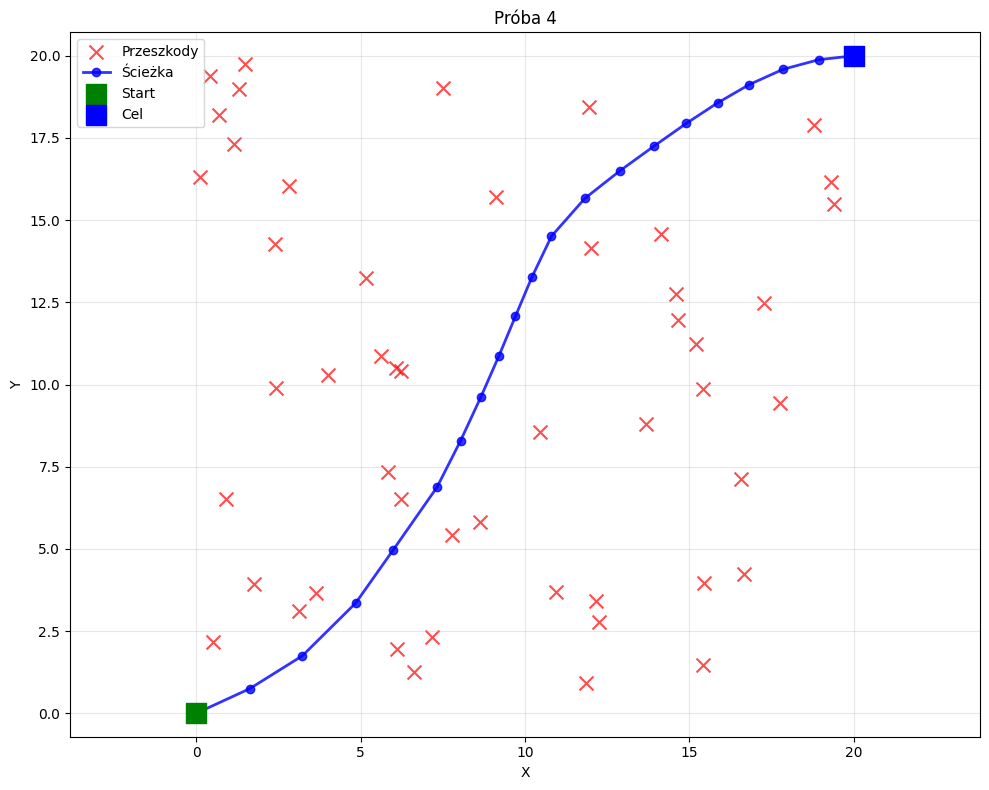


--- PRÓBA 5 ---
Iteracja 0: F = 2898.828212, ||grad|| = 188.014763
Iteracja 50: F = 84.264627, ||grad|| = 1.658125
Iteracja 100: F = 76.530813, ||grad|| = 0.335995
Iteracja 150: F = 75.340966, ||grad|| = 0.098721
Iteracja 200: F = 74.894103, ||grad|| = 0.848891
Iteracja 250: F = 73.951161, ||grad|| = 0.302100
Iteracja 300: F = 73.795034, ||grad|| = 0.104634
Iteracja 350: F = 73.776885, ||grad|| = 0.037234
Wartość końcowa funkcji celu: 73.774295


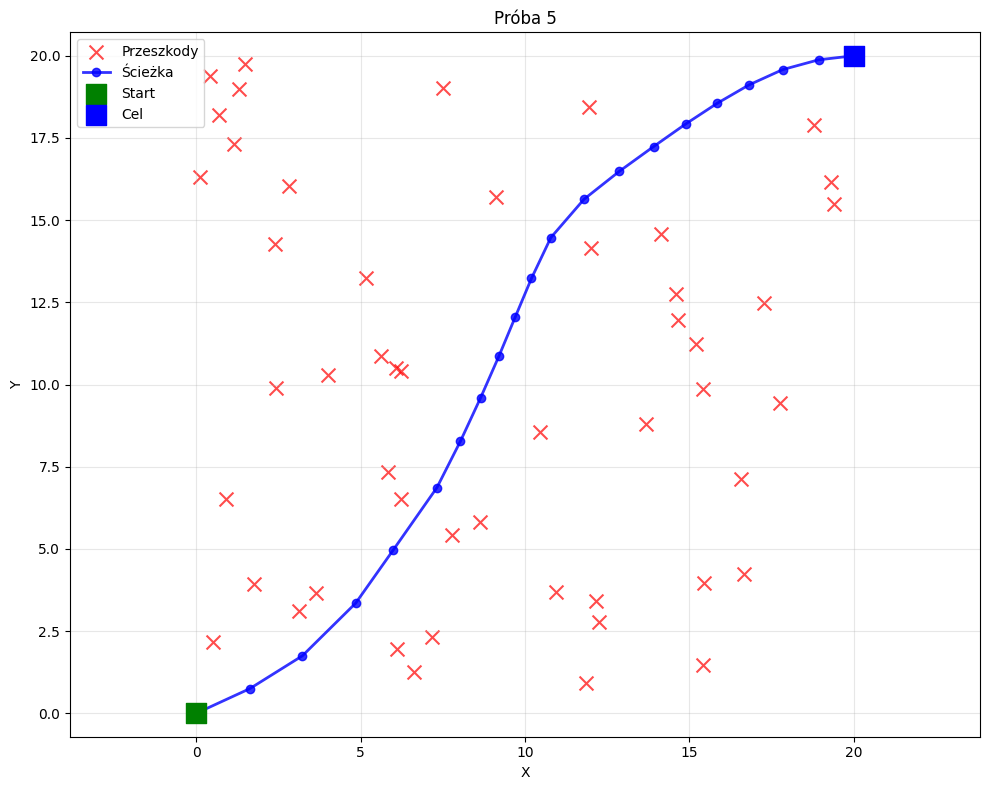


=== PODSUMOWANIE WYNIKÓW ===
Najlepsza próba: 3
Najlepsza wartość funkcji celu: 72.665219
Próba 1: F = 77.210476
Próba 2: F = 77.210476
Próba 3: F = 72.665219
Próba 4: F = 73.773679
Próba 5: F = 73.774295


<Figure size 1200x500 with 0 Axes>

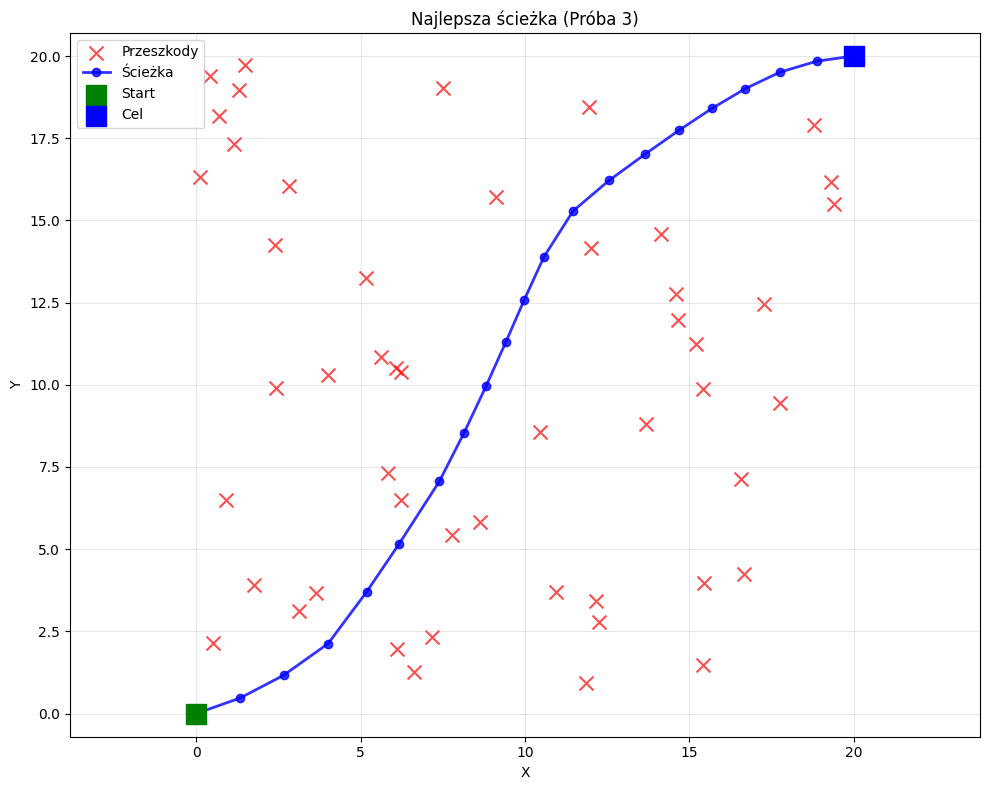

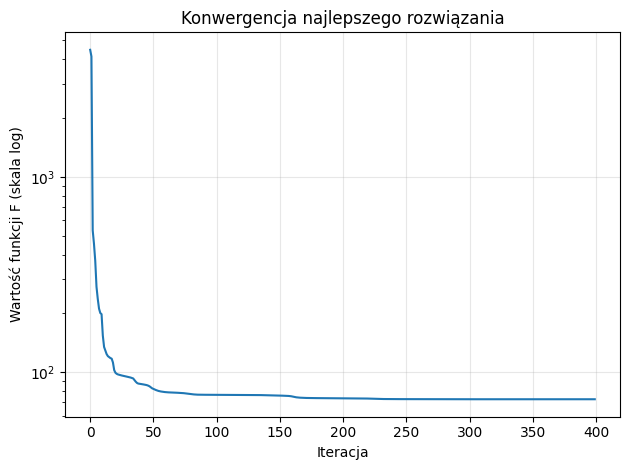


=== MATEMATYCZNY OPIS ALGORYTMU ===

ALGORYTM NAJWIĘKSZEGO SPADKU Z PRZESZUKIWANIEM LINIOWYM:

1. Inicjalizacja:
   - X⁽⁰⁾ = ścieżka początkowa z losowymi punktami pośrednimi
   - k = 0 (licznik iteracji)

2. Dla każdej iteracji k:
   a) Oblicz gradient: ∇F(X⁽ᵏ⁾)
   b) Wyzeruj gradient dla punktów brzegowych:
      ∇F(X⁽ᵏ⁾)[0] = 0, ∇F(X⁽ᵏ⁾)[n] = 0
   c) Sprawdź kryterium stopu: ||∇F(X⁽ᵏ⁾)|| < tol
   d) Znajdź optymalny krok αₖ metodą złotego podziału:
      αₖ = argmin F(X⁽ᵏ⁾ - α∇F(X⁽ᵏ⁾))
   e) Aktualizuj: X⁽ᵏ⁺¹⁾ = X⁽ᵏ⁾ - αₖ∇F(X⁽ᵏ⁾)
   f) k = k + 1

3. Zwróć optymalną ścieżkę X*

GRADIENT FUNKCJI CELU:
∂F/∂x⁽ⁱ⁾ = -2λ₁ ∑ⱼ₌₁ᵏ (x⁽ⁱ⁾ - r⁽ʲ⁾)/(ε + ||x⁽ⁱ⁾ - r⁽ʲ⁾||²)² + 
           2λ₂[składnik długości ścieżki zależny od pozycji i]



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Ustawienie ziarna dla powtarzalności wyników
np.random.seed(42)

def compute_objective_function(X, R, lambda1, lambda2, epsilon):
    """
    Oblicza wartość funkcji celu F(X).
    
    Args:
        X: macierz punktów ścieżki (n+1, 2)
        R: macierz przeszkód (k, 2)
        lambda1: waga składnika unikania przeszkód
        lambda2: waga składnika długości ścieżki
        epsilon: mała stała zapobiegająca dzieleniu przez zero
    
    Returns:
        Wartość funkcji celu F
    """
    n = X.shape[0] - 1  # liczba odcinków
    k = R.shape[0]      # liczba przeszkód
    
    # Pierwszy składnik: unikanie przeszkód
    obstacle_term = 0
    for i in range(n + 1):
        for j in range(k):
            dist_sq = np.sum((X[i] - R[j])**2)
            obstacle_term += 1 / (epsilon + dist_sq)
    
    # Drugi składnik: minimalizacja długości ścieżki
    path_length_term = 0
    for i in range(n):
        path_length_term += np.sum((X[i+1] - X[i])**2)
    
    F = lambda1 * obstacle_term + lambda2 * path_length_term
    return F

def compute_gradient(X, R, lambda1, lambda2, epsilon):
    """
    Oblicza gradient funkcji celu F względem X.
    
    Wyprowadzenie gradientu:
    
    F(X) = λ₁ ∑ᵢ₌₀ⁿ ∑ⱼ₌₁ᵏ 1/(ε + ||x⁽ⁱ⁾ - r⁽ʲ⁾||²) + λ₂ ∑ᵢ₌₀ⁿ⁻¹ ||x⁽ⁱ⁺¹⁾ - x⁽ⁱ⁾||²
    
    ∂F/∂x⁽ⁱ⁾ = λ₁ ∑ⱼ₌₁ᵏ ∂/∂x⁽ⁱ⁾ [1/(ε + ||x⁽ⁱ⁾ - r⁽ʲ⁾||²)] + λ₂ ∂/∂x⁽ⁱ⁾[path_terms]
    
    Dla pierwszego składnika:
    ∂/∂x⁽ⁱ⁾ [1/(ε + ||x⁽ⁱ⁾ - r⁽ʲ⁾||²)] = -2(x⁽ⁱ⁾ - r⁽ʲ⁾)/(ε + ||x⁽ⁱ⁾ - r⁽ʲ⁾||²)²
    
    Dla drugiego składnika:
    - Jeśli i = 0: ∂F/∂x⁽⁰⁾ = 2λ₂(x⁽⁰⁾ - x⁽¹⁾)
    - Jeśli 0 < i < n: ∂F/∂x⁽ⁱ⁾ = 2λ₂(2x⁽ⁱ⁾ - x⁽ⁱ⁻¹⁾ - x⁽ⁱ⁺¹⁾)
    - Jeśli i = n: ∂F/∂x⁽ⁿ⁾ = 2λ₂(x⁽ⁿ⁾ - x⁽ⁿ⁻¹⁾)
    """
    n = X.shape[0] - 1
    k = R.shape[0]
    gradient = np.zeros_like(X)
    
    # Gradient składnika unikania przeszkód
    for i in range(n + 1):
        for j in range(k):
            diff = X[i] - R[j]
            dist_sq = np.sum(diff**2)
            denominator = (epsilon + dist_sq)**2
            gradient[i] -= 2 * lambda1 * diff / denominator
    
    # Gradient składnika długości ścieżki
    for i in range(n + 1):
        if i == 0:  # punkt początkowy
            gradient[i] += 2 * lambda2 * (X[i] - X[i+1])
        elif i == n:  # punkt końcowy
            gradient[i] += 2 * lambda2 * (X[i] - X[i-1])
        else:  # punkty pośrednie
            gradient[i] += 2 * lambda2 * (2*X[i] - X[i-1] - X[i+1])
    
    return gradient

def golden_section_search(f, a, b, tol=1e-6):
    """
    Przeszukiwanie liniowe metodą złotego podziału.
    
    Args:
        f: funkcja jednowymiarowa do minimalizacji
        a, b: przedział poszukiwań
        tol: tolerancja
    
    Returns:
        Optymalny krok alpha
    """
    phi = (1 + np.sqrt(5)) / 2  # złoty podział
    c = b - (b - a) / phi
    d = a + (b - a) / phi
    
    while abs(b - a) > tol:
        if f(c) < f(d):
            b = d
        else:
            a = c
        
        c = b - (b - a) / phi
        d = a + (b - a) / phi
    
    return (a + b) / 2

def steepest_descent_with_line_search(X_init, R, lambda1, lambda2, epsilon, max_iter=400):
    """
    Algorytm największego spadku z przeszukiwaniem liniowym.
    
    Kroki algorytmu:
    1. Oblicz gradient F względem X
    2. Wyzeruj gradient dla punktów początkowego i końcowego
    3. Znajdź optymalny krok α metodą złotego podziału
    4. Zaktualizuj X: X_new = X - α * gradient
    5. Powtarzaj aż do zbieżności lub osiągnięcia max_iter
    """
    X = X_init.copy()
    n = X.shape[0] - 1
    objective_values = []
    
    for iteration in range(max_iter):
        # Oblicz gradient
        grad = compute_gradient(X, R, lambda1, lambda2, epsilon)
        
        # Wyzeruj gradient dla punktów początkowego i końcowego
        grad[0] = 0  # x^(0)
        grad[n] = 0  # x^(n)
        
        # Oblicz wartość funkcji celu
        f_val = compute_objective_function(X, R, lambda1, lambda2, epsilon)
        objective_values.append(f_val)
        
        # Sprawdź kryterium stopu
        grad_norm = np.linalg.norm(grad)
        if grad_norm < 1e-6:
            print(f"Zbieżność osiągnięta w iteracji {iteration}")
            break
        
        # Przeszukiwanie liniowe metodą złotego podziału
        def line_search_function(alpha):
            X_new = X - alpha * grad
            return compute_objective_function(X_new, R, lambda1, lambda2, epsilon)
        
        # Znajdź początkowy przedział dla przeszukiwania liniowego
        alpha_max = 1.0
        while line_search_function(alpha_max) > f_val:
            alpha_max *= 0.5
            if alpha_max < 1e-10:
                alpha_max = 1e-10
                break
        
        # Złoty podział
        alpha_opt = golden_section_search(line_search_function, 0, alpha_max)
        
        # Aktualizacja
        X = X - alpha_opt * grad
        
        if iteration % 50 == 0:
            print(f"Iteracja {iteration}: F = {f_val:.6f}, ||grad|| = {grad_norm:.6f}")
    
    return X, objective_values

def initialize_path(start, end, n):
    """Inicjalizacja ścieżki z losowymi punktami pośrednimi."""
    X = np.zeros((n + 1, 2))
    X[0] = start
    X[n] = end
    
    # Losowa inicjalizacja punktów pośrednich
    for i in range(1, n):
        X[i] = np.random.uniform(0, 20, 2)
    
    return X

def plot_path_and_obstacles(X, R, title="Ścieżka robota"):
    """Wizualizacja ścieżki i przeszkód."""
    plt.figure(figsize=(10, 8))
    
    # Rysuj przeszkody
    plt.scatter(R[:, 0], R[:, 1], c='red', s=100, marker='x', 
                label='Przeszkody', alpha=0.7)
    
    # Rysuj ścieżkę
    plt.plot(X[:, 0], X[:, 1], 'b-o', linewidth=2, markersize=6, 
             label='Ścieżka', alpha=0.8)
    
    # Oznacz punkt początkowy i końcowy
    plt.scatter(X[0, 0], X[0, 1], c='green', s=200, marker='s', 
                label='Start', zorder=5)
    plt.scatter(X[-1, 0], X[-1, 1], c='blue', s=200, marker='s', 
                label='Cel', zorder=5)
    
    plt.xlim(-1, 21)
    plt.ylim(-1, 21)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')

# Parametry zadania
n = 20  # liczba odcinków
k = 50  # liczba przeszkód
start_point = np.array([0, 0])
end_point = np.array([20, 20])
lambda1 = 1
lambda2 = 1
epsilon = 1e-13
max_iterations = 400

# Generowanie przeszkód
R = np.random.uniform(0, 20, (k, 2))

print("=== OPTYMALIZACJA ŚCIEŻKI ROBOTA ===")
print(f"Parametry:")
print(f"- Liczba odcinków (n): {n}")
print(f"- Liczba przeszkód (k): {k}")
print(f"- Punkt startowy: {start_point}")
print(f"- Punkt końcowy: {end_point}")
print(f"- λ₁ = {lambda1}, λ₂ = {lambda2}")
print(f"- ε = {epsilon}")
print(f"- Maksymalna liczba iteracji: {max_iterations}")

# Przeprowadzenie optymalizacji dla 5 różnych inicjalizacji
results = []
plt.figure(figsize=(15, 10))

for trial in range(5):
    print(f"\n--- PRÓBA {trial + 1} ---")
    
    # Inicjalizacja ścieżki
    X_init = initialize_path(start_point, end_point, n)
    
    # Optymalizacja
    X_opt, obj_values = steepest_descent_with_line_search(
        X_init, R, lambda1, lambda2, epsilon, max_iterations
    )
    
    results.append({
        'initial_path': X_init.copy(),
        'optimized_path': X_opt.copy(),
        'objective_values': obj_values,
        'final_objective': obj_values[-1]
    })
    
    print(f"Wartość końcowa funkcji celu: {obj_values[-1]:.6f}")
    
    # Wykres konwergencji dla pierwszej próby
    if trial == 0:
        # plt.subplot(2, 3, 1)
        plt.semilogy(obj_values)
        plt.title('Konwergencja funkcji celu')
        plt.xlabel('Iteracja')
        plt.ylabel('Wartość funkcji F (skala log)')
        plt.grid(True, alpha=0.3)
    
    # Wizualizacja ścieżek
    # plt.subplot(2, 3, trial + 2)
    plot_path_and_obstacles(X_opt, R, f'Próba {trial + 1}')

    plt.tight_layout()
    plt.show()

# Podsumowanie wyników
print("\n=== PODSUMOWANIE WYNIKÓW ===")
best_trial = min(range(5), key=lambda i: results[i]['final_objective'])
print(f"Najlepsza próba: {best_trial + 1}")
print(f"Najlepsza wartość funkcji celu: {results[best_trial]['final_objective']:.6f}")

for i, result in enumerate(results):
    print(f"Próba {i+1}: F = {result['final_objective']:.6f}")

# Wykres najlepszej ścieżki
plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
plot_path_and_obstacles(results[best_trial]['optimized_path'], R, 
                       f'Najlepsza ścieżka (Próba {best_trial + 1})')

plt.tight_layout()
plt.show()

# plt.subplot(1, 2, 2)
plt.semilogy(results[best_trial]['objective_values'])
plt.title('Konwergencja najlepszego rozwiązania')
plt.xlabel('Iteracja')
plt.ylabel('Wartość funkcji F (skala log)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== MATEMATYCZNY OPIS ALGORYTMU ===")
print("""
ALGORYTM NAJWIĘKSZEGO SPADKU Z PRZESZUKIWANIEM LINIOWYM:

1. Inicjalizacja:
   - X⁽⁰⁾ = ścieżka początkowa z losowymi punktami pośrednimi
   - k = 0 (licznik iteracji)

2. Dla każdej iteracji k:
   a) Oblicz gradient: ∇F(X⁽ᵏ⁾)
   b) Wyzeruj gradient dla punktów brzegowych:
      ∇F(X⁽ᵏ⁾)[0] = 0, ∇F(X⁽ᵏ⁾)[n] = 0
   c) Sprawdź kryterium stopu: ||∇F(X⁽ᵏ⁾)|| < tol
   d) Znajdź optymalny krok αₖ metodą złotego podziału:
      αₖ = argmin F(X⁽ᵏ⁾ - α∇F(X⁽ᵏ⁾))
   e) Aktualizuj: X⁽ᵏ⁺¹⁾ = X⁽ᵏ⁾ - αₖ∇F(X⁽ᵏ⁾)
   f) k = k + 1

3. Zwróć optymalną ścieżkę X*

GRADIENT FUNKCJI CELU:
∂F/∂x⁽ⁱ⁾ = -2λ₁ ∑ⱼ₌₁ᵏ (x⁽ⁱ⁾ - r⁽ʲ⁾)/(ε + ||x⁽ⁱ⁾ - r⁽ʲ⁾||²)² + 
           2λ₂[składnik długości ścieżki zależny od pozycji i]
""")